In [3]:
import dask as dask 
from dask import compute, persist
from dask.distributed import Client, progress

client = dask.distributed.Client(processes=True)
client

tornado.application - ERROR - Multiple exceptions in yield list
Traceback (most recent call last):
  File "C:\Users\sh952381\AppData\Local\Continuum\anaconda2\lib\site-packages\tornado\gen.py", line 849, in callback
    result_list.append(f.result())
  File "C:\Users\sh952381\AppData\Local\Continuum\anaconda2\lib\site-packages\tornado\concurrent.py", line 260, in result
    raise_exc_info(self._exc_info)
  File "C:\Users\sh952381\AppData\Local\Continuum\anaconda2\lib\site-packages\tornado\gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "C:\Users\sh952381\AppData\Local\Continuum\anaconda2\lib\site-packages\distributed\deploy\local.py", line 192, in _start_worker
    raise gen.TimeoutError("Worker failed to start")
TimeoutError: Worker failed to start
tornado.application - ERROR - Multiple exceptions in yield list
Traceback (most recent call last):
  File "C:\Users\sh952381\AppData\Local\Continuum\anaconda2\lib\site-packages\tornado\gen.py", line 849, in callback
   

TimeoutError: Worker failed to start

In [2]:
import dask.dataframe as dd

# Subset of the columns to use
cols = ['Year', 'Month', 'DayOfWeek', 'Distance', 'DepDelay', 'CRSDepTime', 'UniqueCarrier', 'Origin', 'Dest']

# Create the dataframe
# File location and type

# A small subset of the data of approx 25000 records, has been taken to try out the example
# Data source: http://stat-computing.org/dataexpo/2009/the-data.html
df = dd.read_csv('/dbfs/FileStore/tables/22000.csv', usecols=cols, storage_options={'anon': True})

#df = df.sample(frac=0.2) # we blow out ram otherwise

is_delayed = (df.DepDelay.fillna(16) > 15)
print(is_delayed)

df['CRSDepTime'] = df['CRSDepTime'].clip(upper=2399)
del df['DepDelay']

df, is_delayed = persist(df, is_delayed)
progress(df, is_delayed)
df.head(10)

WindowsError: [Error 3] The system cannot find the path specified: '\\dbfs\\FileStore\\tables\\22000.csv'

In [ ]:
print(is_delayed.head(10))
df2 = dd.get_dummies(df.categorize()).persist()


In [ ]:
data_train, data_test = df2.random_split([0.7, 0.3], 
                                         random_state=1234)
labels_train, labels_test = is_delayed.random_split([0.7, 0.3], 
                                                    random_state=1234)

In [ ]:
%%time
import dask_xgboost as dxgb

params = {'objective': 'binary:logistic', 'nround': 1000, 
          'max_depth': 16, 'nthread': 4, 'num_workers': 6, 'eta': 0.01, 'subsample': 0.5, 
          'min_child_weight': 1}

bst = dxgb.train(client, params, data_train, labels_train)
bst

In [ ]:
# Use normal XGBoost model with normal Pandas
import xgboost as xgb
dtest = xgb.DMatrix(data_test.head())
bst.predict(dtest)


In [ ]:
# Or use dask-xgboost to predict in parallel across the cluster
predictions = dxgb.predict(client, bst, data_test).persist()
predictions

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
print(roc_auc_score(labels_test.compute(), 
                    predictions.compute()))

In [ ]:
import matplotlib.pyplot as plt
#%matplotlib inline # matplotlib inline doesnt work this way in Databricks

fpr, tpr, _ = roc_curve(labels_test.compute(), predictions.compute())
tpr

In [ ]:
fpr

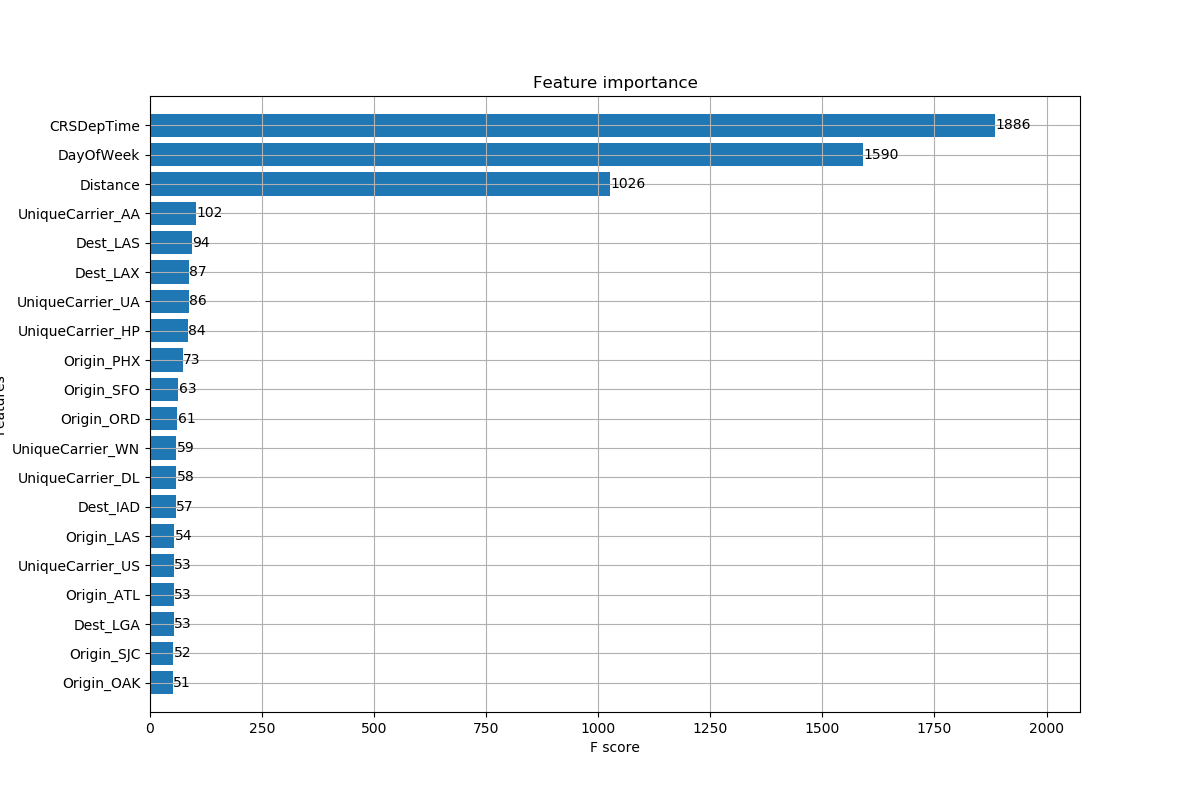

In [11]:
import xgboost as xgb
fig, ax = plt.subplots(figsize=(12, 8))

ax = xgb.plot_importance(bst, ax=ax, height=0.8, max_num_features=20)
display(fig)

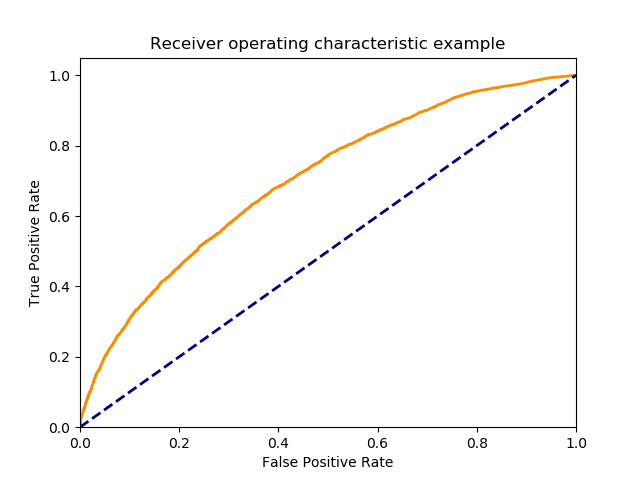

In [12]:
# Taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
plt.figure(figsize=(8, 8))
lw = 2
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
#ax.set_legend(loc="lower right")
# Doesnt work yet - trying to resolve the display ...
# Based on: https://docs.databricks.com/user-guide/visualizations/matplotlib-and-ggplot.html
display(fig)